#**PART 1**
 **(Creating Baseline Binary Skin Lesion Classification Model)**

*We will use only skin lesion images for binary classification- whether the skin lesion is malignant(causing cancer) or banign(non-cancerous).*

###Pre-Processing

In [ ]:
#Downloading dataset HAM10000 using kaggle -

from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets list
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25           3309        102  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset               11KB  2022-09-30 04:05:11           2805         81  1.0              
thedevastator/a-complete-history-of-nobel-prize-winners         Nobel Prize Winners                                   1MB  2022-10-08 00:09:57            660         24  1.0              
thedevastator/fast-food-re

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip -d /content/data_folder

Streaming output truncated to the last 5000 lines.
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/data_folder/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/data_folder/ham

In [ ]:
#Importing required libraries,modules and checking versions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
# Import modules and check versions
import google
import glob
import itertools
import os
import pickle
import PIL
import seaborn as sns
from glob import glob
from google.colab import drive
from PIL import Image
from platform import python_version
from google.colab import drive
from keras.applications.resnet import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from numpy import expand_dims
from platform import python_version

%matplotlib inline

# Versions
print("Version Python:",python_version())
print()   
print("Version Matplotlib:",matplotlib.__version__)
print("Version NumPy:",np.__version__)
print("Version Pandas:",pd.__version__)
print("Version PIL:",PIL.__version__)
print("Version Seaborn:",sns.__version__)
print("Version TensorFlow:",tf.__version__)


Version Python: 3.7.14

Version Matplotlib: 3.2.2
Version NumPy: 1.21.6
Version Pandas: 1.3.5
Version PIL: 7.1.2
Version Seaborn: 0.11.2
Version TensorFlow: 2.9.2


In [ ]:
#Some other Installations-
!pip install imbalanced-learn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 36.4 MB/s 
     |████████████████████████████████| 199 kB 68.8 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
import pandas as pd
metadata = pd.read_csv('/content/data_folder/HAM10000_metadata.csv')
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
# Data inspection: outlier and missing data detection and handling

#Unique values per column 
for col in metadata:
    print(metadata[col].nunique(),"unique values in " + col + ":",np.sort(metadata[col].unique()))
print()


7470 unique values in lesion_id: ['HAM_0000000' 'HAM_0000001' 'HAM_0000002' ... 'HAM_0007626' 'HAM_0007627'
 'HAM_0007628']
10015 unique values in image_id: ['ISIC_0024306' 'ISIC_0024307' 'ISIC_0024308' ... 'ISIC_0034318'
 'ISIC_0034319' 'ISIC_0034320']
7 unique values in dx: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
4 unique values in dx_type: ['confocal' 'consensus' 'follow_up' 'histo']
18 unique values in age: [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 nan]
3 unique values in sex: ['female' 'male' 'unknown']
15 unique values in localization: ['abdomen' 'acral' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'unknown' 'upper extremity']



In [ ]:
# Missing values ('NA' or 'unknown') 
print("Number of 'NA' in 'age':", metadata['age'].isna().sum())
print("Number of 'unknown' in 'sex':", len(metadata[metadata['sex']=='unknown']))
print("Number of 'unknown' in 'localization':", len(metadata[metadata['localization']=='unknown']))
print()


Number of 'NA' in 'age': 57
Number of 'unknown' in 'sex': 57
Number of 'unknown' in 'localization': 234



We have 57 null values in age.Dropping these values can cause loss of metadata.
Let's replace them with mean age 

In [ ]:
# Drop instances where values for 'age', 'sex', and 'localization' are all missing  
initial_length = len(metadata)

metadata['age'].fillna(metadata['age'].mean(),inplace=True)
metadata = metadata.drop(metadata[(metadata['localization'] == 'unknown') & (metadata['sex'] == 'unknown')].index)
# Missing values ('NA' or 'unknown') 
print("Number of 'NA' values in 'age' column :", metadata['age'].isna().sum())
print("Number of 'unknown' values in 'sex' column:", len(metadata[metadata['sex']=='unknown']))
print("Number of 'unknown' in 'localization'column :", len(metadata[metadata['localization']=='unknown']))
print()


Number of 'NA' values in 'age' column : 0
Number of 'unknown' values in 'sex' column: 10
Number of 'unknown' in 'localization'column : 187



In [ ]:
# Percentage missing (after initial drop)
print("Number of instances with multiple missing values :",sum((len(metadata[(metadata['sex'] == 'unknown') & (metadata['localization'] == 'unknown')].index),len(metadata[(metadata['sex'] == 'unknown') & (metadata['age'].isna())].index),len(metadata[(metadata['localization'] == 'unknown') & (metadata['age'].isna())].index))))
print("Percentage of missing cases for 'age':", round((metadata['age'].isna().sum()/initial_length*100),1),"%")
print("Percentage of missing cases for 'sex':", round((len(metadata[metadata['sex'] == 'unknown'])/initial_length*100),1),"%")
print("Percentage of missing cases for 'localization':", round((len(metadata[metadata['localization'] == 'unknown'])/initial_length*100),1),"%")
print()

# Drop all remaining rows containing NA's (10) and rows containing value 'unknown' (10 + 187)  
metadata = metadata.dropna()
metadata = metadata[metadata.sex != 'unknown']
metadata = metadata[metadata.localization != 'unknown']
print("Percentage of complete cases:", round((len(metadata)/initial_length*100),1),"%")



Number of instances with multiple missing values : 0
Percentage of missing cases for 'age': 0.0 %
Percentage of missing cases for 'sex': 0.1 %
Percentage of missing cases for 'localization': 1.9 %

Percentage of complete cases: 97.6 %


In [ ]:
#Checking null values-
metadata.head(974)

lesion_id      image_id   dx    dx_type   age   sex localization
0    HAM_0000118  ISIC_0027419  bkl      histo  80.0  male        scalp
1    HAM_0000118  ISIC_0025030  bkl      histo  80.0  male        scalp
2    HAM_0002730  ISIC_0026769  bkl      histo  80.0  male        scalp
3    HAM_0002730  ISIC_0025661  bkl      histo  80.0  male        scalp
4    HAM_0001466  ISIC_0031633  bkl      histo  75.0  male          ear
..           ...           ...  ...        ...   ...   ...          ...
989  HAM_0000613  ISIC_0031253  bkl  consensus  60.0  male         hand
990  HAM_0005101  ISIC_0024643  bkl  consensus  35.0  male      abdomen
991  HAM_0002355  ISIC_0029202  bkl  consensus  35.0  male      abdomen
992  HAM_0006912  ISIC_0026205  bkl  consensus  35.0  male         back
993  HAM_0005626  ISIC_0031619  bkl  consensus  65.0  male         face

[974 rows x 7 columns]

In [ ]:
# Create dictionaries of full name of lesions, type of lesion, localization and image paths
lesions = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}
#codes for all multiple lesion classses
lesion_classes_dict ={
    0:'akiec',
    1:'bcc',
    2:'bkl',
    3:'df',
    4:'nv',
    5:'mel',
    6:'vasc'
}
#malignant skin lesion can cause cancer .
lesion_type = {
    'akiec': 'Malignant',
    'bcc': 'Malignant', 
    'bkl': 'Benign',
    'df': 'Benign',
    'mel': 'Malignant',
    'nv': 'Benign',
    'vasc': 'Benign'   
}
#Sun exposed and no-sun areas of the body
localizations = {
    'abdomen': 'No Sun',
    'acral': 'No Sun',
    'back': 'No Sun',
    'chest': 'No Sun',
    'ear': 'Sun',
    'face': 'Sun',
    'foot': 'No Sun',
    'genital': 'No Sun',
    'hand': 'Sun',
    'lower extremity': 'Sun',
    'neck': 'Sun',
    'scalp': 'Sun',
    'trunk': 'No Sun',
    'upper extremity': 'Sun'
}

In [ ]:
ham_data_folder = '../content/data_folder'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(ham_data_folder, '*', '*.jpg'))}
 

In [ ]:
metadata['dx_full'] = metadata['dx'].map(lesions.get) 
metadata['dx_cat'] = pd.Categorical(metadata['dx_full']).codes
metadata['image_path'] = metadata['image_id'].map(imageid_path_dict.get)
metadata['lesion_type'] = metadata['dx'].map(lesion_type.get) 
metadata['lesion_type_cat'] = pd.Categorical(metadata['lesion_type']).codes
metadata.loc[metadata['age'] >= 50, 'age_group'] = 'Older'
metadata['age_group'] = metadata['age_group'].fillna('Younger')
metadata['age_cat'] = pd.Categorical(metadata['age_group']).codes
metadata['sex_cat'] = pd.Categorical(metadata['sex']).codes
metadata['loc_group'] =metadata['localization'].map(localizations.get) 
metadata['loc_cat'] = pd.Categorical(metadata['loc_group']).codes

metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                          dx_full  dx_cat  \
0  Benign keratosis-like lesions        2   
1  Benign keratosis-like lesions        2   
2  Benign keratosis-like lesions        2   
3  Benign keratosis-like lesions        2   
4  Benign keratosis-like lesions        2   

                                          image_path lesion_type  \
0  ../content/data_folder/ham10000_images_part_1/...      Benign   
1  ../content/data_folder/ham10000_images_part_1/...      Benign   
2  ../content/data_folder/ham10000_images_part_1/...      Benign   
3  ../content/data_folder/ham10000_images_part_1/...      Benign   
4  ../content/data_folder/ham10000_images_part_2/...      Benign   

   lesion_type_cat age_group  age_cat  sex_cat loc_group  loc_cat  
0                0     Older        0        1       Sun        1  
1                0     Older        0        1       Sun        1  
2                0     Older        0        1       Sun        1  
3                0     Older        0        1       Sun        1  
4                0     Older        0        1       Sun        1

In [ ]:
images_per_lesion = metadata["lesion_id"].value_counts()

def unique(x):  
    if images_per_lesion[x] > 1:
        return False
    else:
        return True

metadata["unique"] = metadata["lesion_id"].map(unique)

metadata = metadata[['lesion_id','image_id','unique','dx','dx_full','dx_cat','lesion_type','lesion_type_cat','dx_type','age','age_group','age_cat','sex','sex_cat','localization','loc_group','loc_cat','image_path']]

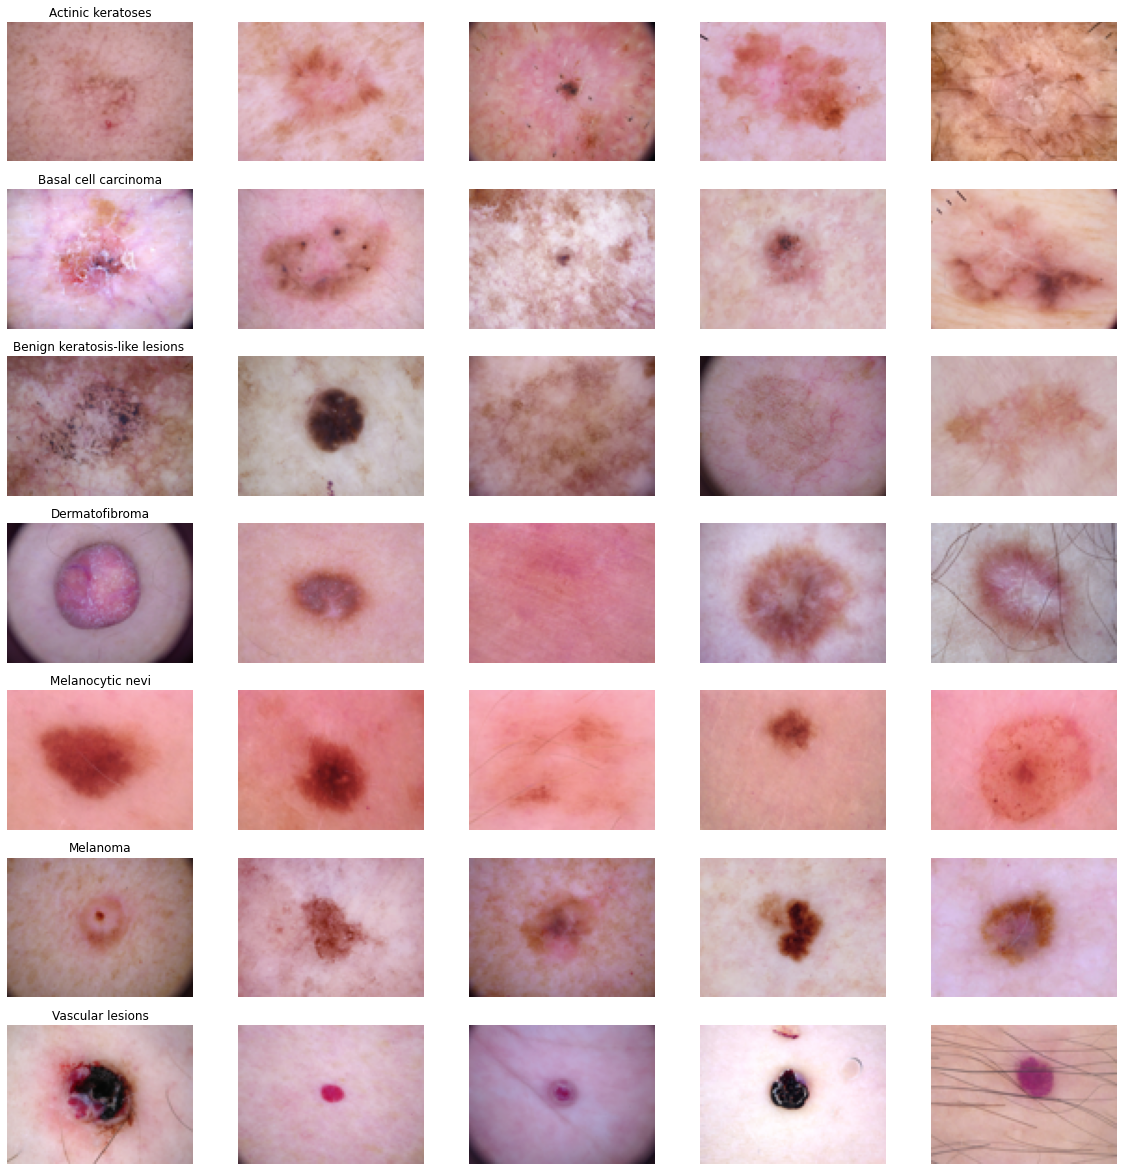

In [ ]:
# Add images to dataframe and output samples of all lasion types 
# (Derived from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy)

# Add images to dataframe and resize images from 600x450 to 100x75
metadata['image'] = metadata['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

# Samples of each lesion type
fig, m_axs = plt.subplots(7, 5, figsize = (4*5, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,metadata.sort_values(['dx_full']).groupby('dx_full')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

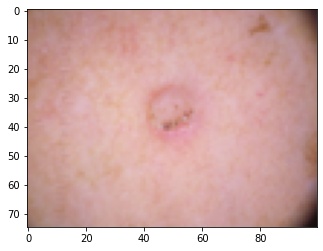

In [ ]:
plt.imshow(metadata['image'][7])

In [ ]:
#Pickle serializes the python objects so they can be saved in a file (like byte stream)and loaded in a program whenever we want in formats 

pd.to_pickle(metadata, os.path.join('/content/data_folder', 'data.pkl'))

#Model

In [ ]:
# Set seeds
from numpy.random import seed
import tensorflow as tf
seed(42)
tf.random.set_seed(42)

In [ ]:
metadata = pd.read_pickle(os.path.join('/content/data_folder', 'data.pkl'))

In [ ]:
#Create training, validation amd test sets (Derived from: https://www.kaggle.com/kaimingk/skin-cancer-mnist-ham10000)

# Split 70%, 10%, 20%. Test and validation, together 30%, should be from unique ID's only
size_val_test = 0.3 * len(metadata)
val_test_ratio_from_unique = size_val_test/len(metadata[metadata.unique == True])

# Training data = remainder of unique ID's + non-uniques. Split is stratified by lesion type (benign/malignant)
bb_metadata_train_unique, bb_metadata_val_test = train_test_split(metadata[metadata["unique"] == True], test_size = val_test_ratio_from_unique, stratify=metadata[metadata["unique"] == True]["lesion_type_cat"], random_state = 42)
bb_metadata_train = pd.concat((bb_metadata_train_unique, metadata[metadata["unique"] == False]), axis = 0)

# Split validation and test sets. Split is stratified by lesion type (benign/malignant)
bb_metadata_validation, bb_metadata_test = train_test_split(bb_metadata_val_test, test_size = 0.6667, stratify=bb_metadata_val_test["lesion_type_cat"], random_state = 42)

# Class balancing (random oversampling)
X = bb_metadata_train.drop(['lesion_type_cat'], axis=1)
y = bb_metadata_train['lesion_type_cat']

X_test = bb_metadata_test.drop(['lesion_type_cat'], axis=1)
y_test = bb_metadata_test['lesion_type_cat']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

ros = RandomOverSampler(random_state=42)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

bb_metadata_train = pd.concat([X_resampled, y_resampled], axis=1)
bb_metadata_test = pd.concat([X_test_resampled, y_test_resampled], axis=1)

# Create variables for feature (x) and target (y) training, validation and test sets
bb_metadata_train_x = np.asarray(bb_metadata_train['image'].tolist())
bb_metadata_validation_x = np.asarray(bb_metadata_validation['image'].tolist())
bb_metadata_test_x = np.asarray(bb_metadata_test['image'].tolist())

bb_metadata_train_y = np.asarray(bb_metadata_train['lesion_type_cat'].tolist())
bb_metadata_validation_y = np.asarray(bb_metadata_validation['lesion_type_cat'].tolist())
bb_metadata_test_y = np.asarray(bb_metadata_test['lesion_type_cat'].tolist())

# One-hot encoding of target variable
bb_num_classes = len(np.sort(metadata['lesion_type_cat'].unique()))

bb_metadata_train_y = to_categorical(bb_metadata_train_y, num_classes = bb_num_classes)
bb_metadata_validation_y = to_categorical(bb_metadata_validation_y, num_classes = bb_num_classes)
bb_metadata_test_y = to_categorical(bb_metadata_test_y, num_classes = bb_num_classes)

In [ ]:
print("Train: " + str(bb_metadata_train.shape[0] / metadata.shape[0]))
print("Validation: " + str(bb_metadata_validation.shape[0] / metadata.shape[0]))
print("Test: " + str(bb_metadata_test.shape[0] /metadata.shape[0]))

Train: 1.065192917818033
Validation: 0.0999897656329956
Test: 0.35861221983420327


###Performing Data Augmentation

In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range = 60,
    zoom_range = 0.2,  
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,  
    vertical_flip = True,  
    shear_range = 10)

In [ ]:
# Fit data augmentation
data_augmentation.fit(bb_metadata_train_x)

###Resnet50 model -

In [ ]:
# Creating ResNet model (Derived from: https://www.kaggle.com/jnegrini/ham10000-analysis-and-model-comparison)

# Model parameters
input_shape = (75, 100, 3)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 50
batch_size = 32

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')
history = History()

# Define model architecture
base_model = ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');

Resnet50model_UnimodalBinary= Sequential()
Resnet50model_UnimodalBinary.add(base_model)
Resnet50model_UnimodalBinary.add(Dropout(0.2))
Resnet50model_UnimodalBinary.add(Dense(128, activation="relu"))
Resnet50model_UnimodalBinary.add(Dropout(0.2))
Resnet50model_UnimodalBinary.add(Dense(bb_num_classes, activation = 'softmax'))
Resnet50model_UnimodalBinary.summary()

# Layers in ResNet are pretrained (ImageNet)
for layer in base_model.layers:
    layer.trainable = False

# Compile model
Resnet50model_UnimodalBinary.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23,850,242
Trainable params: 23,797,122
Non-trainable params: 53,120
________________________________________

**Model Architecture-**

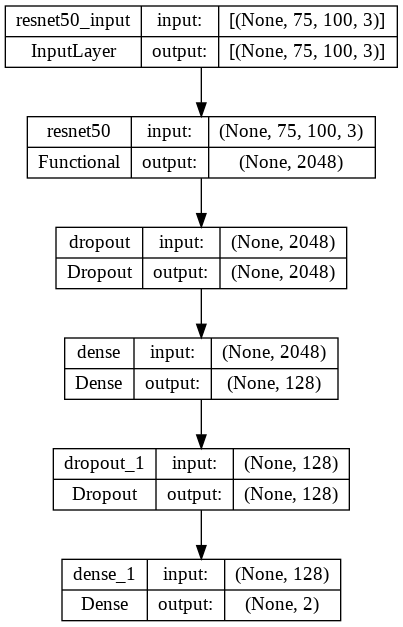

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(Resnet50model_UnimodalBinary, to_file=os.path.join('/content/data_folder', 'unimodal_architecture.png'),show_shapes = True)

**Train and save model**

In [ ]:
# Fit and save model 
Resnet50model_UnimodalBinary_history = Resnet50model_UnimodalBinary.fit(data_augmentation.flow(bb_metadata_train_x,bb_metadata_train_y, batch_size=batch_size),
                        epochs = epochs, validation_data = (bb_metadata_validation_x,bb_metadata_validation_y),
                        verbose = 1, steps_per_epoch=bb_metadata_train_x.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor, history])


Epoch 1/50
325/325 [==============================] - 44s 87ms/step - loss: 0.5806 - accuracy: 0.6932 - val_loss: 0.2536 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 2/50
325/325 [==============================] - 23s 71ms/step - loss: 0.5186 - accuracy: 0.7302 - val_loss: 0.2054 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 3/50
325/325 [==============================] - 25s 77ms/step - loss: 0.5119 - accuracy: 0.7321 - val_loss: 0.2155 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 4/50
325/325 [==============================] - 23s 72ms/step - loss: 0.5012 - accuracy: 0.7418 - val_loss: 0.2616 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 5/50
325/325 [==============================] - 23s 71ms/step - loss: 0.5019 - accuracy: 0.7439 - val_loss: 0.1882 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 6/50
325/325 [==============================] - 23s 71ms/step - loss: 0.4949 - accuracy: 0.7478 - val_loss: 0.1816 - val_accuracy: 0.8987 - lr: 0.0010
Epoch 7/50
325/325 [==============================] - 24s 

#Evaluation

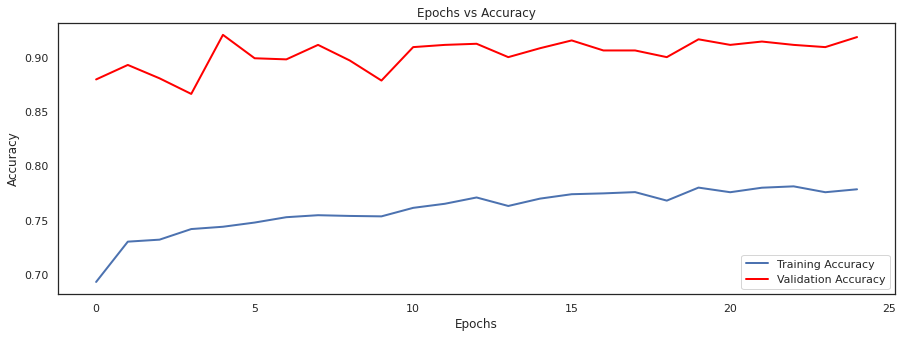

In [ ]:
# visualization of overall model performance 
plt.figure(1 , figsize = (15 ,5))
plt.plot(history.history['accuracy'],label = 'Training Accuracy',linewidth = 2)
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy', color="red", linewidth = 2)
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

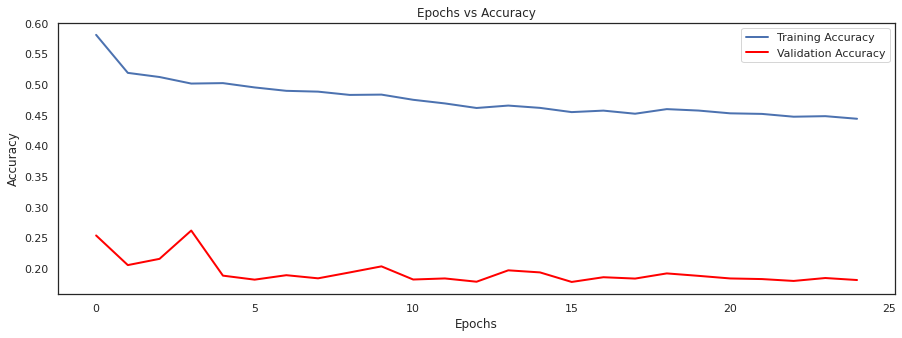

In [ ]:
# visualization of overall model performance 
plt.figure(1 , figsize = (15 ,5))
plt.plot(history.history['loss'],label = 'Training Accuracy',linewidth = 2)
plt.plot(history.history['val_loss'],label = 'Validation Accuracy', color="red", linewidth = 2)
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

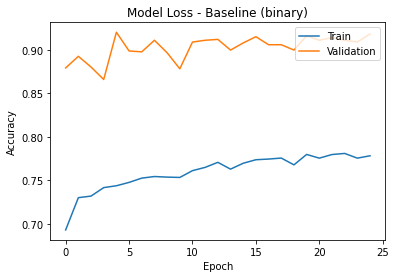

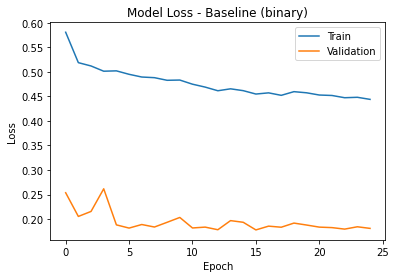

In [ ]:
# Accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss - Baseline (binary)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Accuracy - Baseline (binary).png')
#plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

# Loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - Baseline (binary)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Loss - Baseline (binary).png')
#plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

In [ ]:
print("Maximum Validation Accuracy of Baseline Binary Model is :", round(max(Resnet50model_UnimodalBinary_history.history['val_accuracy'])*100,4),"%")
print("Maximum Training Accuracy of Baseline Binary Model is :", round(max(Resnet50model_UnimodalBinary_history.history['accuracy'])*100,4),"%")
print("Maximum Training loss of Baseline binary model is :", round(max(Resnet50model_UnimodalBinary_history.history['loss'])*100,4),"%")
print("Maximum Validation loss of Baseline binary model is  :", round(max(Resnet50model_UnimodalBinary_history.history['val_loss'])*100,4),"%")

Maximum Validation Accuracy of Baseline Binary Model is : 92.0164 %
Maximum Training Accuracy of Baseline Binary Model is : 78.1033 %
Maximum Training loss of Baseline binary model is : 58.0571 %
Maximum Validation loss of Baseline binary model is  : 26.1647 %


Testing on some images-

In [ ]:
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

Original Shape of image is :  (450, 600, 3)


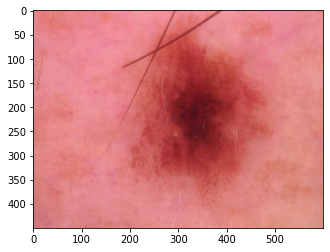

In [ ]:
test_image = np.asarray(pil_image.open('test_nv.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [ ]:
resized_image = np.asarray(pil_image.open('test_nv.jpg').resize((100,75)))
image_array = np.asarray(resized_image.tolist())
test_image2 = image_array.reshape(1,75,100,3)

New Shape of image is :  (75, 100, 3)


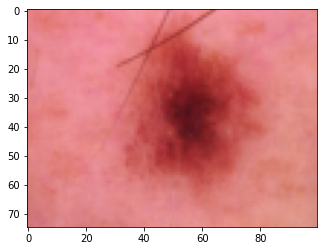

In [ ]:
plt.imshow(resized_image)
print('New Shape of image is : ',resized_image.shape)

In [ ]:
prediction_class = Resnet50model_UnimodalBinary.predict(test_image2)
prediction_class = np.argmax(prediction_class,axis=1)
prediction_class

1/1 [==============================] - 1s 1s/step


array([0])

Actual Output: Benign
Predicted Output: Benign
Non Cancerous Skin Lesion


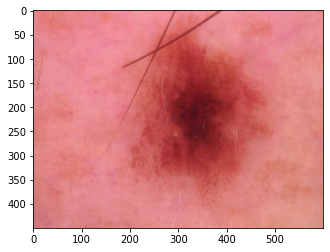

In [ ]:
df2 = pd.DataFrame(metadata)
df3=df2[df2['lesion_type_cat']==0]['lesion_type']

plt.imshow(test_image)
if(df3[0]=='Malignant'):
  x='Cancerous Skin Lesion'
else:
  x='Non Cancerous Skin Lesion'
  print('Actual Output:',lesion_type['nv'])
  print('Predicted Output:',df3[0])
  print(x)

In [ ]:
bb_y_test = np.argmax(bb_metadata_test_y, axis=1)
bb_y_pred_probs = Resnet50model_UnimodalBinary.predict(bb_metadata_test_x)
bb_y_pred = np.array(list(map(lambda x: np.argmax(x), bb_y_pred_probs)))

110/110 [==============================] - 4s 28ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report( bb_y_test,bb_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1752
           1       0.90      0.78      0.84      1752

    accuracy                           0.85      3504
   macro avg       0.85      0.85      0.85      3504
weighted avg       0.85      0.85      0.85      3504



In [ ]:
from sklearn.metrics import precision_score

print("Precision score: {}".format(precision_score(bb_y_test,bb_y_pred)))

Precision score: 0.9034391534391535


In [ ]:
from sklearn.metrics import f1_score

print("F1 score: {}".format(f1_score(bb_y_test,bb_y_pred)))

F1 score: 0.8370098039215687


#LIME


In [ ]:
!pip install lime
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 6.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=dd58103721fd77e593144efd406966537d7d8af17a053dbaf626b63118d5be13
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns;sns.set(style="white")
import matplotlib.pyplot as plt
%matplotlib inline
import os
import zipfile
import random
import cv2
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import keras
from keras.models import Sequential

from keras.layers import Convolution2D,MaxPooling2D,Dropout,Dense,Flatten,BatchNormalization,Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing
from keras.utils import np_utils


import warnings
warnings.simplefilter("ignore")

In [ ]:
df = pd.read_csv("/content/data_folder/hmnist_28_28_RGB.csv")

print("Our orignal data-set have {} rows and {} columns. \n" .format(df.shape[0], df.shape[1]))

df.head()

Our orignal data-set have 10015 rows and 2353 columns. 



pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [ ]:
meta = pd.read_csv("/content/data_folder/HAM10000_metadata.csv")
print("Meta dataframe has {} image information.".format(meta.shape[0]))
meta.head()

Meta dataframe has 10015 image information.


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

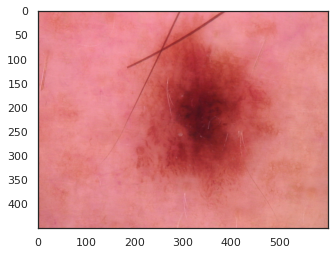

In [ ]:
image = cv2.cvtColor(cv2.imread('test_nv.jpg'),cv2.COLOR_BGR2RGB)
image_array = Image.fromarray(image , 'RGB')
resize_img = image_array.resize((75 , 100))
plt.imshow(image)

In [ ]:
nv_ls=[]
mel_ls=[]
bkl_ls=[]
bcc_ls=[]
akiec_ls=[]
vasc_ls=[]
df_ls=[] 

from PIL import Image 

for i in os.listdir("/content/data_folder/HAM10000_images_part_1"):
  try:
    image = cv2.cvtColor(cv2.imread("/content/data_folder/HAM10000_images_part_1/"+i),cv2.COLOR_BGR2RGB)
    image = cv2.imread
    image_array = Image.fromarray(image , 'RGB')
    resize_img = image_array.resize((100,75))
    dx = meta.loc[meta["image_id"]==i.split(".")[0], "dx"].values[0]

    if dx == "nv":
      nv_ls.append(resize_img)
    elif dx == "mel":
      mel_ls.append(resize_img)
    elif dx == "bkl":
      bkl_ls.append(resize_img)
    elif dx == "bcc":
      bcc_ls.append(resize_img)
    elif dx == "akiec":
      akiec_ls.append(resize_img)
    elif dx == "vasc":
      vasc_ls.append(resize_img)
    elif dx == "df":
      df_ls.append(resize_img)
        
  except AttributeError:
    pass

for u in os.listdir("/content/data_folder/HAM10000_images_part_2"):
  try:
    image = cv2.cvtColor(cv2.imread("/content/data_folder/HAM10000_images_part_2/"+u),cv2.COLOR_BGR2RGB)
    image_array = Image.fromarray(image,'RGB')
    resize_img = image_array.resize((100,75))
    dx = meta.loc[meta["image_id"]==u.split(".")[0], "dx"].values[0]
    if dx == "nv":
      nv_ls.append(resize_img)
    elif dx == "mel":
      mel_ls.append(resize_img)
    elif dx == "bkl":
      bkl_ls.append(resize_img)
    elif dx == "bcc":
      bcc_ls.append(resize_img)
    elif dx == "akiec":
      akiec_ls.append(resize_img)
    elif dx == "vasc":
      vasc_ls.append(resize_img)
    elif dx == "df":
      df_ls.append(resize_img)
  except AttributeError:
    pass


In [ ]:
bcc_up = random.choices(population=bcc_ls, k=1500)
akiec_up = random.choices(population=akiec_ls, k=1000)
vasc_up = random.choices(population=vasc_ls, k=1000)
df_up = random.choices(population=df_ls, k=1000)


nv_label = ["nv" for i in range(len(nv_ls))]
mel_label = ["mel" for i in range(len(mel_ls))]
bkl_label = ["bkl" for i in range(len(bkl_ls))]
bcc_label = ["bcc" for i in range(len(bcc_up))]
akiec_label = ["akiec" for i in range(len(akiec_up))]
vasc_label = ["vasc" for i in range(len(vasc_up))]
df_label = ["df" for i in range(len(df_up))]


or_data= nv_ls + mel_ls + bkl_ls+ bcc_up+ akiec_up+ vasc_up+ df_up
org_data = [np.array(i) for i in or_data]
or_labels= nv_label + mel_label + bkl_label + bcc_label + akiec_label + vasc_label+ df_label

org_data = np.array(org_data)
or_labels = np.array(or_labels)
# or_labels = [label[0] for label in or_labels.tolist()]

print('Before Augmentaion')
print('Data : {} | labels : {}'.format(org_data.shape , len(or_labels)))

Before Augmentaion
Data : (8987, 75, 100, 3) | labels : 8987


['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']


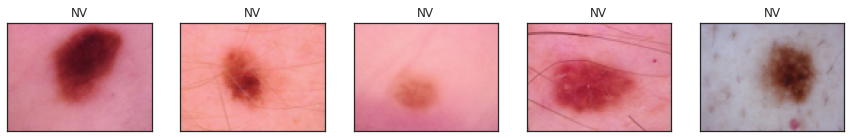

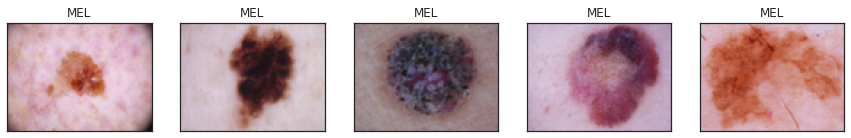

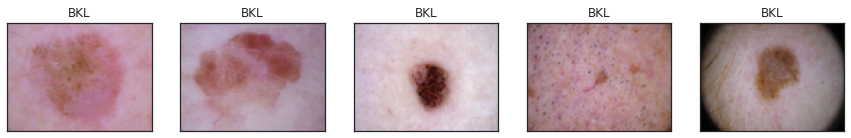

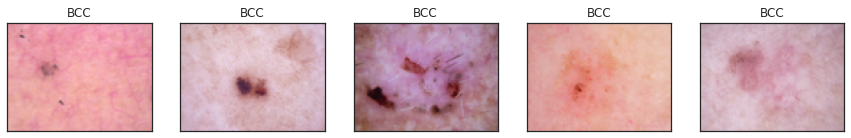

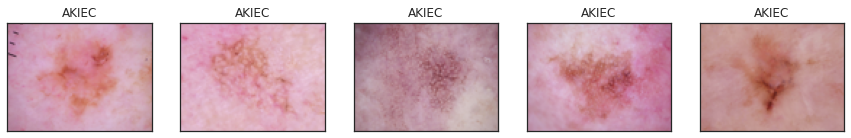

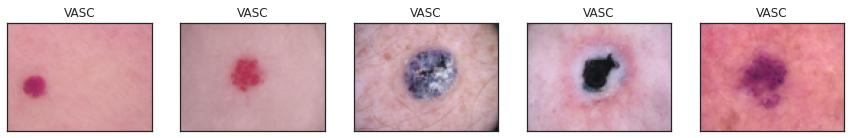

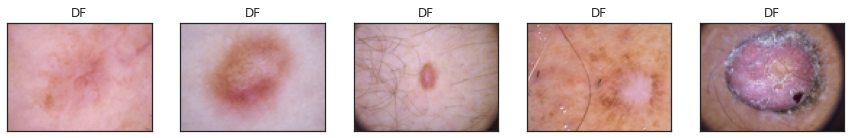

In [ ]:
uni_labels=[]
for label in range(len(or_labels)):
  if or_labels[label] not in uni_labels:
    uni_labels.append(or_labels[label])
print(uni_labels)

for uni in uni_labels:
  ls=[]
  for label in range(len(or_labels)):
    if or_labels[label] == uni:
      ls.append(label)
  ls =  random.choices(population=ls, k=5)

  plt.figure(figsize=(15,5))
  for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(org_data[ls[i-1]])
    plt.title(uni.upper())
    plt.xticks([])
    plt.yticks([])



In [ ]:
data = []
labels = []

for index in range(len(or_data)):
  resize_img = or_data[index]
  dx = or_labels[index]
  rotated90 = resize_img.rotate(90)
  blur = cv2.blur(np.array(resize_img),(10,10))
  data.append(np.array(resize_img))
  data.append(np.array(rotated90))
  data.append(np.array(blur))
  labels.append(dx)
  labels.append(dx)
  labels.append(dx)

data = np.array(data)
labels = np.array(labels)
# labels = [label[0] for label in labels.tolist()]
print('After Augmentaion')
print('Data : {} | labels : {}'.format(data.shape , len(labels)))

After Augmentaion
Data : (26961, 75, 100, 3) | labels : 26961


1/1 [==============================] - 0s 438ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


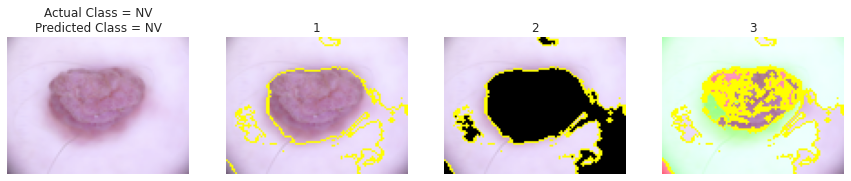

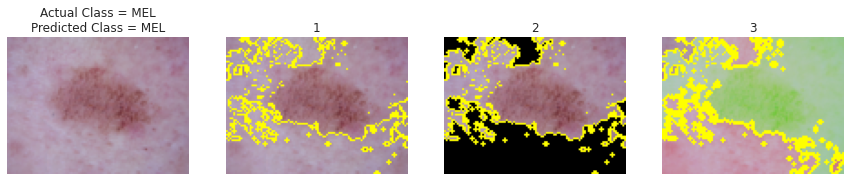

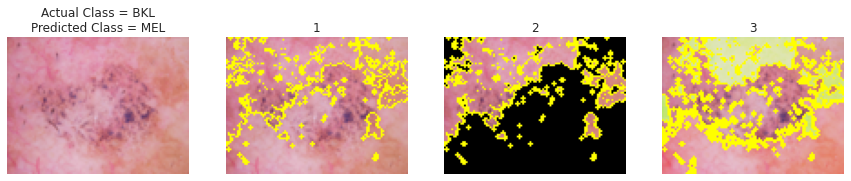

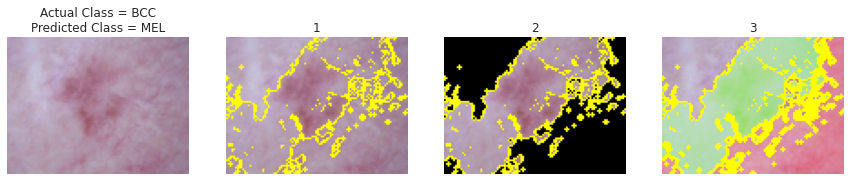

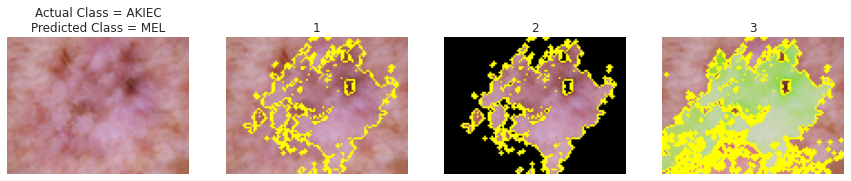

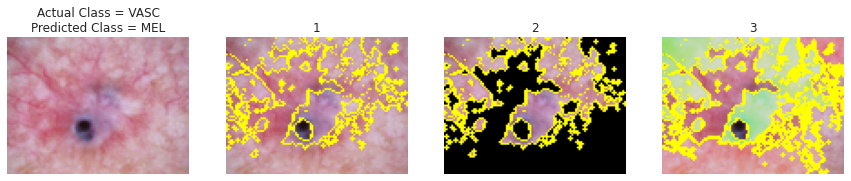

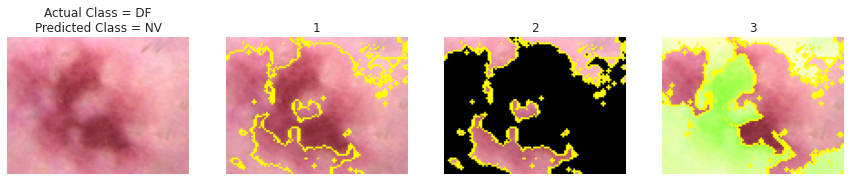

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer(verbose = False)

n=0

title = ["NV","MEL", "BKL", "BCC", "AKIEC", "VASC", "DF"]

rando_num = random.randint(1,100)
pre =  np.array([np.array(i[rando_num])  for i in [nv_ls,  mel_ls, bkl_ls, bcc_ls, akiec_ls, vasc_ls, df_ls]])
pre = Resnet50model_UnimodalBinary.predict(pre).round(0).argmax(axis=1).tolist()

for ls in [nv_ls,  mel_ls, bkl_ls, bcc_ls, akiec_ls, vasc_ls, df_ls]:
  explanation = explainer.explain_instance(
      np.array(ls[rando_num]).astype('double'), 
      classifier_fn = Resnet50model_UnimodalBinary.predict, 
      top_labels=100, 
      hide_color=0, 
      num_samples=1000,)

  temp, mask = explanation.get_image_and_mask(
      explanation.top_labels[0], 
      positive_only=True, 
      num_features=5, 
      hide_rest=False
  )
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,15))
  ax1.imshow(np.array(ls[rando_num]))
  ax2.imshow(mark_boundaries(temp /2 +0.5, mask))
  temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  ax3.imshow(mark_boundaries(temp1/2+0.5, mask1))
  temp3, mask3= explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  ax4.imshow(mark_boundaries(temp3/2+0.5, mask3))
  temp4, mask4 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  ax5.imshow(mark_boundaries(temp4/ 2 + 0.5, mask4))
  ax1.set_title("Actual Class = {}\nPredicted Class = {}".format(title[n], title[pre[n]]))
  ax1.axis('off')
  ax2.set_title("1")
  ax2.axis('off')
  ax3.set_title("2")
  ax3.axis('off')
  ax4.set_title("3")
  ax4.axis('off')
  n+=1

#SHAP NOW-

In [ ]:
model=Resnet50model_UnimodalBinary
title = ["NV","MEL", "BKL", "BCC", "AKIEC", "VASC", "DF"]
target=["nv","mel", "bkl", "bcc", "akiec", "vasc", "df"]
for ls in range(len(title)):

  # define a masker that is used to mask out partitions of the input image, this one uses a blurred background
  masker = shap.maskers.Image("inpaint_telea", (50,50,3))

  # By default the Partition explainer is used for all  partition explainer
  explainer = shap.Explainer(model, masker, output_names=target)
  rando_num = random.randint(1,len(data))
  model_pred = model.predict(data[rando_num-1:rando_num]).argmax(axis=1)[0]
  # print(model_pred)
  # here we use 500 evaluations of the underlying model to estimate the SHAP values
  print("Actual Class = {} Predicted Class = {}".format(title[labels[rando_num]], title[model_pred]))
  shap_values = explainer(data[rando_num-1:rando_num], max_evals=1000, batch_size=32, outputs=shap.Explanation.argsort.flip[:7])
  shap.image_plot(shap_values)


InvalidArgumentError: ignored

#GRAD-CAM

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
image = cv2.imread('/content/test_nv.jpg')
image = cv2.resize(image, (100,75))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = Resnet50model_UnimodalBinary.predict(image)
i = np.argmax(preds[0])

1/1 [==============================] - 0s 36ms/step


In [ ]:
print(i)

0


In [ ]:
for idx in range(len(Resnet50model_UnimodalBinary.layers)):
  print(Resnet50model_UnimodalBinary.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

resnet50
dropout
dense
dropout_1
dense_1


In [ ]:
icam = GradCAM(Resnet50model_UnimodalBinary, i, 'dense_1') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (100,75))
image = cv2.imread('/content/test_nv.jpg')
image = cv2.resize(image, (100,75))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

InvalidArgumentError: ignored

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)